## Schrodinger's Equation

In [26]:
import numpy
from scipy.linalg import solve
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [27]:
def generateMatrix(N, sigma):
    
    #Diagonal
    d = numpy.diag(numpy.ones(N-2)*(1+sigma+0j))
    
    #Upper diagonal
    ud = numpy.diag(numpy.ones(N-3)*-1, 1)
    
    #Lower diagonal
    ld = numpy.diag(numpy.ones(N-3)*-1, -1)
    
    A = d + ud + ld
    
    return A

In [28]:
def genRHS(psi, sigma):
    
    x = psi[1:-1]*(sigma+1) + psi[:-2] + psi[2:]
    
    #Dirichlet boundary conditions
    x[0] += psi[0]
    x[-1] += psi[0]
    
    return x

In [29]:
def CrankNicolson(psi, A, nt, sigma):
    
    for t in range(nt):
        psin = psi.copy()
        x = genRHS(psin, sigma)
        
        psi_interior = solve(A, x)
        psi[1:-1] = psi_interior
        
    return psi

In [30]:
L = 1
nx = 51

h = 6.62607004e-34 #[m^2*kg/s]
hbar = h/2j*numpy.pi
m = 6.6464764063e-27 #[kg] - mass of Helium ion
dx = L/(nx-1)


psii = numpy.zeros(nx, dtype = numpy.complex)
psii[0] = 1

sigma = 0.5
dt = (2j*(dx**2)*m)/(sigma*hbar)
nt = 10

A = generateMatrix(nx, sigma)

In [31]:
print(A)

[[ 1.5+0.j -1.0+0.j  0.0+0.j ...,  0.0+0.j  0.0+0.j  0.0+0.j]
 [-1.0+0.j  1.5+0.j -1.0+0.j ...,  0.0+0.j  0.0+0.j  0.0+0.j]
 [ 0.0+0.j -1.0+0.j  1.5+0.j ...,  0.0+0.j  0.0+0.j  0.0+0.j]
 ..., 
 [ 0.0+0.j  0.0+0.j  0.0+0.j ...,  1.5+0.j -1.0+0.j  0.0+0.j]
 [ 0.0+0.j  0.0+0.j  0.0+0.j ..., -1.0+0.j  1.5+0.j -1.0+0.j]
 [ 0.0+0.j  0.0+0.j  0.0+0.j ...,  0.0+0.j -1.0+0.j  1.5+0.j]]


In [32]:
psi = CrankNicolson(psii.copy(), A, nt, sigma)

/home/gil/anaconda3/lib/python3.4/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


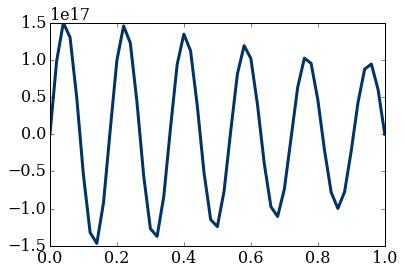

In [33]:
x = numpy.linspace(0,L,nx)

pyplot.plot(x, psi, color='#003366', ls='-', lw=3);

In [34]:
print(psi)

[  1.00000000e+00+0.j   9.82183708e+16+0.j   1.49777433e+17+0.j
   1.30289568e+17+0.j   4.92242421e+16+0.j  -5.47228447e+16-0.j
  -1.32197131e+17-0.j  -1.46729667e+17-0.j  -9.19688537e+16-0.j
   5.57696584e+15+0.j   9.94512481e+16+0.j   1.45485286e+17+0.j
   1.22657484e+17+0.j   4.26838190e+16+0.j  -5.60308959e+16-0.j
  -1.26940785e+17-0.j  -1.37393550e+17-0.j  -8.36747602e+16-0.j
   7.87443718e+15+0.j   9.38609304e+16+0.j   1.34500972e+17+0.j
   1.12052358e+17+0.j   3.84640844e+16+0.j  -5.09999861e+16-0.j
  -1.14753310e+17-0.j  -1.24258309e+17-0.j  -7.67321708e+16-0.j
   4.43222364e+15+0.j   8.12592633e+16+0.j   1.19012469e+17+0.j
   1.01852971e+17+0.j   3.93020834e+16+0.j  -3.90207118e+16-0.j
  -9.74857320e+16-0.j  -1.10633566e+17-0.j  -7.41152088e+16-0.j
  -5.77450460e+15-0.j   6.31286809e+16+0.j   1.02208052e+17+0.j
   9.52260691e+16+0.j   4.66256692e+16+0.j  -2.11801961e+16-0.j
  -7.81533110e+16-0.j  -9.98299444e+16-0.j  -7.76354538e+16-0.j
  -2.20748404e+16-0.j   4.22613065e+16+0

In [35]:
psi_conj = numpy.conj(psi)
probfunc = psi*psi_conj

print(psi_conj)

[  1.00000000e+00-0.j   9.82183708e+16-0.j   1.49777433e+17-0.j
   1.30289568e+17-0.j   4.92242421e+16-0.j  -5.47228447e+16+0.j
  -1.32197131e+17+0.j  -1.46729667e+17+0.j  -9.19688537e+16+0.j
   5.57696584e+15-0.j   9.94512481e+16-0.j   1.45485286e+17-0.j
   1.22657484e+17-0.j   4.26838190e+16-0.j  -5.60308959e+16+0.j
  -1.26940785e+17+0.j  -1.37393550e+17+0.j  -8.36747602e+16+0.j
   7.87443718e+15-0.j   9.38609304e+16-0.j   1.34500972e+17-0.j
   1.12052358e+17-0.j   3.84640844e+16-0.j  -5.09999861e+16+0.j
  -1.14753310e+17+0.j  -1.24258309e+17+0.j  -7.67321708e+16+0.j
   4.43222364e+15-0.j   8.12592633e+16-0.j   1.19012469e+17-0.j
   1.01852971e+17-0.j   3.93020834e+16-0.j  -3.90207118e+16+0.j
  -9.74857320e+16+0.j  -1.10633566e+17+0.j  -7.41152088e+16+0.j
  -5.77450460e+15+0.j   6.31286809e+16-0.j   1.02208052e+17-0.j
   9.52260691e+16-0.j   4.66256692e+16-0.j  -2.11801961e+16+0.j
  -7.81533110e+16+0.j  -9.98299444e+16+0.j  -7.76354538e+16+0.j
  -2.20748404e+16+0.j   4.22613065e+16-0

/home/gil/anaconda3/lib/python3.4/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


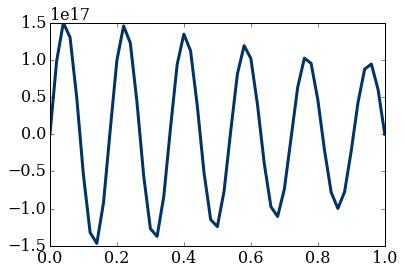

In [36]:
pyplot.plot(x, psi_conj, color='#003366', ls='-', lw=3);